<a href="https://colab.research.google.com/github/ywchanna2001/Paddy-Field-Insects-Classification/blob/main/Paddy_Field_Insects_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
# Install the Ultralytics package
!pip install ultralytics

# Import necessary libraries
import os
from ultralytics import YOLO

### Loading roboflow dataset

In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="ZGiIefwMk9l91xuS3pQo")
project = rf.workspace("football-analyzing-system").project("paddy-field-insects-all-classes-ugbpw")
version = project.version(2)
dataset = version.download("yolov8")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 85.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Paddy-Field-Insects-All-Classes-2 in yolov8:: 100%|██████████| 15282/15282 [00:02<00:00, 6092.95it/s]


### Check the number of images per class

Successfully loaded 11 classes from /content/Paddy-Field-Insects-All-Classes-2/data.yaml
Source images path set to: /content/Paddy-Field-Insects-All-Classes-2/train/images
Source labels path set to: /content/Paddy-Field-Insects-All-Classes-2/train/labels

--- Instance Counts per Class ---
Armyworm (ID: 0): 1193 instances
Brown_Planthopper (ID: 1): 781 instances
Crickets (ID: 2): 632 instances
Dragonfly (ID: 3): 148 instances
Mealybug (ID: 4): 905 instances
Rice_Bug (ID: 5): 88 instances
Rice_Gall_Midge (ID: 6): 657 instances
Rice_Water_Weevil (ID: 7): 938 instances
Thrips (ID: 8): 1077 instances
Wasps (ID: 9): 1696 instances
Whorl_Maggot (ID: 10): 672 instances


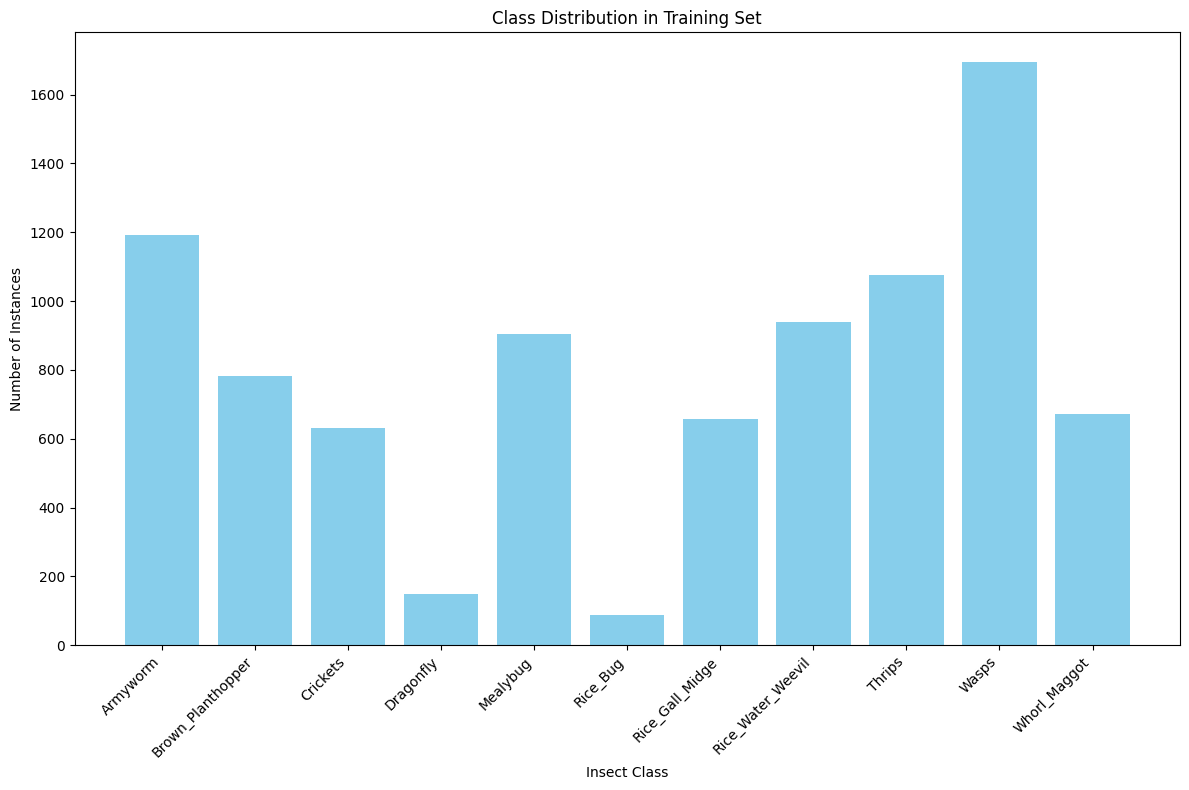


--- Starting to organize dataset into: /content/drive/MyDrive/Organized_Paddy_Insects_Classification/Dataset_Before_Class_Balance ---
Created class folders in Google Drive.

Copying images to their respective class folders...


100%|██████████| 5345/5345 [00:41<00:00, 128.85it/s]


✅ Successfully organized and copied images to Google Drive!


In [6]:
import os
import yaml
from collections import Counter
import matplotlib.pyplot as plt
import shutil
from tqdm import tqdm

# --- 1. CONFIGURATION ---
yaml_file_path = '/content/Paddy-Field-Insects-All-Classes-2/data.yaml'

# --- 2. INITIALIZE VARIABLES AND LOAD DATA FROM YAML ---
class_names = []
train_images_path = ''
train_labels_path = ''

try:
    with open(yaml_file_path, 'r') as file:
        data = yaml.safe_load(file)
        class_names = data['names']

        # --- THIS IS THE KEY FIX ---
        # Get the root directory of the dataset from the yaml file's location
        dataset_root = os.path.dirname(yaml_file_path)
        # Construct the full, correct paths for both images and labels
        train_images_path = os.path.join(dataset_root, data['train'].replace('../', ''))
        train_labels_path = os.path.join(dataset_root, 'train/labels') # Standard YOLO structure

        print(f"Successfully loaded {len(class_names)} classes from {yaml_file_path}")
        print(f"Source images path set to: {train_images_path}")
        print(f"Source labels path set to: {train_labels_path}")

except Exception as e:
    print(f"Error loading or parsing YAML file: {e}")

# --- 3. RUN ANALYSIS AND ORGANIZATION (only if setup was successful) ---
if class_names and os.path.exists(train_images_path) and os.path.exists(train_labels_path):

    # --- COUNT CLASS INSTANCES ---
    class_counts = Counter()
    for filename in os.listdir(train_labels_path):
        if filename.endswith('.txt'):
            with open(os.path.join(train_labels_path, filename), 'r') as f:
                for line in f:
                    try:
                        class_id = int(line.split()[0])
                        class_counts[class_id] += 1
                    except (ValueError, IndexError):
                        continue

    # --- DISPLAY THE RESULTS ---
    print("\n--- Instance Counts per Class ---")
    sorted_counts = sorted(class_counts.items())
    for class_id, count in sorted_counts:
        class_name = class_names[class_id]
        print(f"{class_name} (ID: {class_id}): {count} instances")

    # --- VISUALIZE THE RESULTS ---
    class_ids = [item[0] for item in sorted_counts]
    counts = [item[1] for item in sorted_counts]
    names_for_plot = [class_names[id] for id in class_ids]

    plt.figure(figsize=(12, 8))
    plt.bar(names_for_plot, counts, color='skyblue')
    plt.xlabel('Insect Class')
    plt.ylabel('Number of Instances')
    plt.title('Class Distribution in Training Set')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # --- ORGANIZE AND SAVE DATASET TO GOOGLE DRIVE ---
    DRIVE_OUTPUT_DIR = '/content/drive/MyDrive/Organized_Paddy_Insects_Classification/Dataset_Before_Class_Balance'
    print(f"\n--- Starting to organize dataset into: {DRIVE_OUTPUT_DIR} ---")

    os.makedirs(DRIVE_OUTPUT_DIR, exist_ok=True)
    for name in class_names:
        os.makedirs(os.path.join(DRIVE_OUTPUT_DIR, name), exist_ok=True)
    print("Created class folders in Google Drive.")

    label_files = [f for f in os.listdir(train_labels_path) if f.endswith('.txt')]

    print("\nCopying images to their respective class folders...")
    for label_file in tqdm(label_files):
        present_class_ids = set()
        with open(os.path.join(train_labels_path, label_file), 'r') as f:
            for line in f:
                 try:
                    class_id = int(line.split()[0])
                    present_class_ids.add(class_id)
                 except (ValueError, IndexError):
                    continue

        base_name = os.path.splitext(label_file)[0]
        source_image_path = None
        for ext in ['.jpg', '.jpeg', '.png']:
            # This line now works because train_images_path is correctly defined
            potential_path = os.path.join(train_images_path, base_name + ext)
            if os.path.exists(potential_path):
                source_image_path = potential_path
                break

        if source_image_path is None:
            print(f"Warning: Could not find a matching image for label file: {label_file}")
            continue

        for class_id in present_class_ids:
            class_name = class_names[class_id]
            destination_folder = os.path.join(DRIVE_OUTPUT_DIR, class_name)
            shutil.copy(source_image_path, destination_folder)

    print(f"\n✅ Successfully organized and copied images to Google Drive!")

else:
    print("\nCould not proceed. Check the path to your data.yaml file or the existence of your train directories.")

### Balancing the classes

In [8]:
import cv2
import yaml
import albumentations as A
import random
import numpy as np

# ==============================================================================
# --- 1. CONFIGURATION ---
# ==============================================================================
# Path to the root directory of your downloaded Roboflow dataset
SOURCE_DATASET_DIR = '/content/Paddy-Field-Insects-All-Classes-2'

# Path where the new, balanced dataset will be created
OUTPUT_DATASET_DIR = '/content/Paddy_Insects_Class_Balanced'

# The target number of instances for each class
TARGET_INSTANCES = 1000
# ==============================================================================


# ==============================================================================
# --- V3 - FINAL, ROBUST FUNCTION ---
# This function now fully sanitizes bounding boxes to prevent all coordinate errors.
# ==============================================================================
def get_yolo_labels(label_path):
    """
    Reads a YOLO label file, performs robust sanitization, and returns a
    list of clean bounding boxes.
    """
    sanitized_labels = []
    if not os.path.exists(label_path):
        return sanitized_labels

    with open(label_path, 'r') as f:
        for line in f:
            try:
                parts = line.strip().split()
                if len(parts) < 5:
                    continue

                class_id = int(parts[0])
                x_c, y_c, w, h = [float(p) for p in parts[1:]]

                # --- START OF ROBUST FIX ---
                # 1. Convert YOLO to min/max format
                x_min = x_c - w / 2
                y_min = y_c - h / 2
                x_max = x_c + w / 2
                y_max = y_c + h / 2

                # 2. Clip min/max values to be within [0.0, 1.0]
                x_min = np.clip(x_min, 0.0, 1.0)
                y_min = np.clip(y_min, 0.0, 1.0)
                x_max = np.clip(x_max, 0.0, 1.0)
                y_max = np.clip(y_max, 0.0, 1.0)

                # 3. Convert sanitized min/max back to YOLO
                new_w = x_max - x_min
                new_h = y_max - y_min
                new_x_c = x_min + new_w / 2
                new_y_c = y_min + new_h / 2

                # 4. Only add if the box still has a valid area
                if new_w > 1e-6 and new_h > 1e-6: # Check for a tiny positive area
                    sanitized_labels.append([class_id, new_x_c, new_y_c, new_w, new_h])
                # --- END OF ROBUST FIX ---

            except (ValueError, IndexError):
                print(f"Warning: Skipping malformed line in {label_path}: '{line.strip()}'")
                continue
    return sanitized_labels

def save_yolo_labels(label_path, labels):
    """Saves a list of bounding boxes to a YOLO format label file."""
    with open(label_path, 'w') as f:
        for label in labels:
            class_id = int(label[0])
            coords = ' '.join([f'{c:.6f}' for c in label[1:]])
            f.write(f'{class_id} {coords}\n')

# --- 2. DEFINE AUGMENTATION PIPELINE ---
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=25, p=0.4, border_mode=cv2.BORDER_CONSTANT),
    A.Blur(blur_limit=3, p=0.2),
    A.GaussNoise(p=0.2)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'], min_visibility=0.1))


print("--- Starting Dataset Balancing Script (v3 - Robust) ---")

# --- 3. SETUP DIRECTORIES ---
if os.path.exists(OUTPUT_DATASET_DIR):
    shutil.rmtree(OUTPUT_DATASET_DIR)
    print(f"Removed existing output directory: {OUTPUT_DATASET_DIR}")

for split in ['train', 'valid', 'test']:
    os.makedirs(os.path.join(OUTPUT_DATASET_DIR, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DATASET_DIR, split, 'labels'), exist_ok=True)

print("Created new dataset directory structure.")

# --- 4. LOAD CONFIG and ANALYZE DATASET ---
yaml_path = os.path.join(SOURCE_DATASET_DIR, 'data.yaml')
with open(yaml_path, 'r') as file:
    data_config = yaml.safe_load(file)
    class_names = data_config['names']

source_train_images = os.path.join(SOURCE_DATASET_DIR, 'train/images')
source_train_labels = os.path.join(SOURCE_DATASET_DIR, 'train/labels')

image_files = [f for f in os.listdir(source_train_images) if f.endswith(('.jpg', '.jpeg', '.png'))]

class_instance_counts = Counter()
images_per_class = {i: [] for i in range(len(class_names))}

print("Analyzing source training data...")
for img_file in tqdm(image_files):
    label_file = os.path.splitext(img_file)[0] + '.txt'
    labels = get_yolo_labels(os.path.join(source_train_labels, label_file))
    if not labels:
        continue

    for label in labels:
        class_id = int(label[0])
        class_instance_counts[class_id] += 1
        if img_file not in images_per_class[class_id]:
            images_per_class[class_id].append(img_file)

print("\n--- Initial Class Distribution ---")
for i, name in enumerate(class_names):
    print(f"{name} (ID {i}): {class_instance_counts.get(i, 0)} instances")

# --- 5. COPY VALID & TEST SETS ---
print("\nCopying validation and test sets...")
shutil.copytree(os.path.join(SOURCE_DATASET_DIR, 'valid', 'images'), os.path.join(OUTPUT_DATASET_DIR, 'valid', 'images'), dirs_exist_ok=True)
shutil.copytree(os.path.join(SOURCE_DATASET_DIR, 'valid', 'labels'), os.path.join(OUTPUT_DATASET_DIR, 'valid', 'labels'), dirs_exist_ok=True)
shutil.copytree(os.path.join(SOURCE_DATASET_DIR, 'test', 'images'), os.path.join(OUTPUT_DATASET_DIR, 'test', 'images'), dirs_exist_ok=True)
shutil.copytree(os.path.join(SOURCE_DATASET_DIR, 'test', 'labels'), os.path.join(OUTPUT_DATASET_DIR, 'test', 'labels'), dirs_exist_ok=True)


# --- 6. PERFORM BALANCING ON TRAINING SET ---
print("\n--- Starting Balancing Process ---")
dest_train_images = os.path.join(OUTPUT_DATASET_DIR, 'train/images')
dest_train_labels = os.path.join(OUTPUT_DATASET_DIR, 'train/labels')

final_image_list = set()
final_class_counts = Counter()

# First pass: Undersample by selecting images to keep
print("Step 1: Undersampling classes with >", TARGET_INSTANCES, "instances...")
images_to_process = sorted(image_files)
random.shuffle(images_to_process)

for img_file in tqdm(images_to_process):
    label_file = os.path.splitext(img_file)[0] + '.txt'
    labels = get_yolo_labels(os.path.join(source_train_labels, label_file))

    can_add = True
    for label in labels:
        class_id = int(label[0])
        if class_instance_counts.get(class_id, 0) > TARGET_INSTANCES and final_class_counts[class_id] >= TARGET_INSTANCES:
            can_add = False
            break

    if can_add:
        final_image_list.add(img_file)
        shutil.copy(os.path.join(source_train_images, img_file), os.path.join(dest_train_images, img_file))
        shutil.copy(os.path.join(source_train_labels, label_file), os.path.join(dest_train_labels, label_file))
        for label in labels:
            final_class_counts[int(label[0])] += 1

# Second pass: Oversample with augmentation
print("\nStep 2: Oversampling classes with <", TARGET_INSTANCES, "instances...")
for class_id in range(len(class_names)):
    if final_class_counts[class_id] < TARGET_INSTANCES:
        num_needed = TARGET_INSTANCES - final_class_counts[class_id]
        print(f"Augmenting class '{class_names[class_id]}'. Need {num_needed} more instances.")

        possible_images = images_per_class[class_id]
        if not possible_images:
            print(f"Warning: No source images found for class '{class_names[class_id]}'. Cannot augment.")
            continue

        pbar = tqdm(total=num_needed, desc=f"Augmenting {class_names[class_id]}")
        aug_count = 0
        while final_class_counts[class_id] < TARGET_INSTANCES:
            img_to_aug = random.choice(possible_images)
            img_path = os.path.join(source_train_images, img_to_aug)
            label_path = os.path.join(source_train_labels, os.path.splitext(img_to_aug)[0] + '.txt')

            image = cv2.imread(img_path)
            if image is None:
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            labels = get_yolo_labels(label_path)
            if not labels:
                continue

            bboxes = [l[1:] for l in labels]
            class_labels = [l[0] for l in labels]

            try:
                transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
            except ValueError as e:
                print(f"\nSkipping augmentation for {img_to_aug} due to error: {e}")
                continue

            if transformed['bboxes']:
                base_name = os.path.splitext(img_to_aug)[0]
                new_img_name = f"{base_name}_aug_{aug_count}.jpg"
                new_label_name = f"{base_name}_aug_{aug_count}.txt"

                aug_image = cv2.cvtColor(transformed['image'], cv2.COLOR_RGB2BGR)
                cv2.imwrite(os.path.join(dest_train_images, new_img_name), aug_image)

                new_labels = [[l] + list(b) for l, b in zip(transformed['class_labels'], transformed['bboxes'])]
                save_yolo_labels(os.path.join(dest_train_labels, new_label_name), new_labels)

                initial_count = final_class_counts[class_id]
                for l in new_labels:
                    final_class_counts[int(l[0])] += 1

                instances_added = final_class_counts[class_id] - initial_count
                if instances_added > 0:
                  pbar.update(instances_added)
                aug_count += 1
        pbar.close()

# --- 7. CREATE FINAL YAML and REPORT ---
final_yaml_path = os.path.join(OUTPUT_DATASET_DIR, 'data.yaml')
data_config['train'] = 'train/images'
data_config['val'] = 'valid/images'
data_config['test'] = 'test/images'

# Make sure all paths in yaml are relative for portability
if 'path' in data_config:
    del data_config['path']

with open(final_yaml_path, 'w') as file:
    yaml.dump(data_config, file)

print("\n--- Final Class Distribution ---")
for i, name in enumerate(class_names):
    print(f"{name} (ID {i}): {final_class_counts[i]} instances")

print(f"\n✅ Successfully created balanced dataset at: {OUTPUT_DATASET_DIR}")
print(f"You can now train your YOLO model using the new config file: {final_yaml_path}")

--- Starting Dataset Balancing Script (v3 - Robust) ---
Removed existing output directory: /content/Paddy_Insects_Class_Balanced
Created new dataset directory structure.
Analyzing source training data...


 19%|█▉        | 1038/5345 [00:00<00:00, 10326.09it/s]

 54%|█████▍    | 2906/5345 [00:00<00:00, 7944.22it/s]

 70%|██████▉   | 3726/5345 [00:00<00:00, 7574.33it/s]

 84%|████████▍ | 4499/5345 [00:00<00:00, 6983.50it/s]

100%|██████████| 5345/5345 [00:00<00:00, 7287.18it/s]


--- Initial Class Distribution ---
Armyworm (ID 0): 1193 instances
Brown_Planthopper (ID 1): 781 instances
Crickets (ID 2): 632 instances
Dragonfly (ID 3): 148 instances
Mealybug (ID 4): 882 instances
Rice_Bug (ID 5): 42 instances
Rice_Gall_Midge (ID 6): 657 instances
Rice_Water_Weevil (ID 7): 938 instances
Thrips (ID 8): 1052 instances
Wasps (ID 9): 1696 instances
Whorl_Maggot (ID 10): 588 instances

Copying validation and test sets...



--- Starting Balancing Process ---
Step 1: Undersampling classes with > 1000 instances...


  6%|▌         | 294/5345 [00:00<00:01, 2939.55it/s]

 23%|██▎       | 1235/5345 [00:00<00:01, 3070.71it/s]

 29%|██▉       | 1543/5345 [00:00<00:01, 3052.13it/s]

 40%|███▉      | 2116/5345 [00:00<00:01, 2507.14it/s]

 50%|████▉     | 2661/5345 [00:00<00:01, 2609.33it/s]

 66%|██████▋   | 3547/5345 [00:01<00:00, 2867.54it/s]

 78%|███████▊  | 4193/5345 [00:01<00:00, 3052.99it/s]

 92%|█████████▏| 4899/5345 [00:01<00:00, 3315.94it/s]

100%|██████████| 5345/5345 [00:01<00:00, 2870.94it/s]



Step 2: Oversampling classes with < 1000 instances...
Augmenting class 'Brown_Planthopper'. Need 219 more instances.


Augmenting Brown_Planthopper: 100%|██████████| 219/219 [00:00<00:00, 468.88it/s]


Augmenting class 'Crickets'. Need 368 more instances.


Augmenting Crickets: 100%|██████████| 368/368 [00:04<00:00, 89.25it/s]


Augmenting class 'Dragonfly'. Need 852 more instances.


Augmenting Dragonfly: 100%|██████████| 852/852 [00:10<00:00, 77.76it/s] 


Augmenting class 'Mealybug'. Need 118 more instances.


Augmenting Mealybug: 120it [00:00, 139.85it/s]                         


Augmenting class 'Rice_Bug'. Need 958 more instances.


Augmenting Rice_Bug: 100%|██████████| 958/958 [00:09<00:00, 104.68it/s]


Augmenting class 'Rice_Gall_Midge'. Need 343 more instances.


Augmenting Rice_Gall_Midge: 347it [00:03, 115.31it/s]                         


Augmenting class 'Rice_Water_Weevil'. Need 62 more instances.


Augmenting Rice_Water_Weevil: 100%|██████████| 62/62 [00:00<00:00, 128.46it/s]


Augmenting class 'Whorl_Maggot'. Need 412 more instances.


Augmenting Whorl_Maggot:  38%|███▊      | 157/412 [00:00<00:01, 233.67it/s]

Augmenting Whorl_Maggot:  90%|█████████ | 372/412 [00:01<00:00, 178.57it/s]

Augmenting Whorl_Maggot: 100%|██████████| 412/412 [00:02<00:00, 203.79it/s]


--- Final Class Distribution ---
Armyworm (ID 0): 1012 instances
Brown_Planthopper (ID 1): 1000 instances
Crickets (ID 2): 1000 instances
Dragonfly (ID 3): 1000 instances
Mealybug (ID 4): 1002 instances
Rice_Bug (ID 5): 1000 instances
Rice_Gall_Midge (ID 6): 1004 instances
Rice_Water_Weevil (ID 7): 1000 instances
Thrips (ID 8): 1000 instances
Wasps (ID 9): 1009 instances
Whorl_Maggot (ID 10): 1000 instances

✅ Successfully created balanced dataset at: /content/Paddy_Insects_Class_Balanced
You can now train your YOLO model using the new config file: /content/Paddy_Insects_Class_Balanced/data.yaml


### Organize and Save the BALANCED Dataset

In [11]:
# ==============================================================================
# This script takes the BALANCED dataset and saves it to Google Drive,
# organized by class. RUN THIS AFTER CELL 1 IS FINISHED.
# ==============================================================================


# --- Configuration ---
# This MUST point to the output folder from the script in previous cell
BALANCED_DATASET_DIR = '/content/Paddy_Insects_Class_Balanced'

# This is the final destination in your Google Drive
DRIVE_OUTPUT_DIR = '/content/drive/MyDrive/Organized_Paddy_Insects_Classification/Dataset_After_Class_Balance'


# --- Main Organization Logic ---
print("\n--- Starting to organize BALANCED dataset ---")
yaml_path = os.path.join(BALANCED_DATASET_DIR, 'data.yaml')

if not os.path.exists(yaml_path):
    print(f"❌ ERROR: Cannot find data.yaml in the balanced dataset folder.")
    print(f"Please make sure the script in previous cell has finished and the path '{BALANCED_DATASET_DIR}' is correct.")
else:
    with open(yaml_path, 'r') as file:
        data_config = yaml.safe_load(file)
        class_names = data_config['names']

    train_images_path = os.path.join(BALANCED_DATASET_DIR, 'train/images')
    train_labels_path = os.path.join(BALANCED_DATASET_DIR, 'train/labels')

    print(f"Reading balanced data from: {BALANCED_DATASET_DIR}")
    print(f"Saving organized data to: {DRIVE_OUTPUT_DIR}")

    os.makedirs(DRIVE_OUTPUT_DIR, exist_ok=True)
    for name in class_names:
        os.makedirs(os.path.join(DRIVE_OUTPUT_DIR, name), exist_ok=True)
    print("Created class folders in Google Drive.")

    label_files = [f for f in os.listdir(train_labels_path) if f.endswith('.txt')]

    print("\nCopying balanced and augmented images to their class folders...")
    for label_file in tqdm(label_files):
        present_class_ids = set()
        with open(os.path.join(train_labels_path, label_file), 'r') as f:
            for line in f:
                try:
                    present_class_ids.add(int(line.split()[0]))
                except (ValueError, IndexError):
                    continue

        base_name = os.path.splitext(label_file)[0]
        source_image_path = None
        for ext in ['.jpg', '.jpeg', '.png']:
            potential_path = os.path.join(train_images_path, base_name + ext)
            if os.path.exists(potential_path):
                source_image_path = potential_path
                break

        if source_image_path is None:
            continue

        for class_id in present_class_ids:
            class_name = class_names[class_id]
            destination_folder = os.path.join(DRIVE_OUTPUT_DIR, class_name)
            shutil.copy(source_image_path, destination_folder)

    print(f"\n✅ Successfully organized and copied the BALANCED dataset to Google Drive!")


--- Starting to organize BALANCED dataset ---
Reading balanced data from: /content/Paddy_Insects_Class_Balanced
Saving organized data to: /content/drive/MyDrive/Organized_Paddy_Insects_Classification/Dataset_After_Class_Balance
Created class folders in Google Drive.

Copying balanced and augmented images to their class folders...


100%|██████████| 7517/7517 [01:05<00:00, 113.93it/s]


✅ Successfully organized and copied the BALANCED dataset to Google Drive!


### Checking number of images per class after class balancing

Successfully loaded 11 classes from /content/Paddy_Insects_Class_Balanced/data.yaml
Searching for labels in: /content/Paddy_Insects_Class_Balanced/train/images/../labels

--- Instance Counts per Class ---
Armyworm (ID: 0): 1012 instances
Brown_Planthopper (ID: 1): 1000 instances
Crickets (ID: 2): 1000 instances
Dragonfly (ID: 3): 1000 instances
Mealybug (ID: 4): 1025 instances
Rice_Bug (ID: 5): 1046 instances
Rice_Gall_Midge (ID: 6): 1004 instances
Rice_Water_Weevil (ID: 7): 1000 instances
Thrips (ID: 8): 1025 instances
Wasps (ID: 9): 1009 instances
Whorl_Maggot (ID: 10): 1084 instances


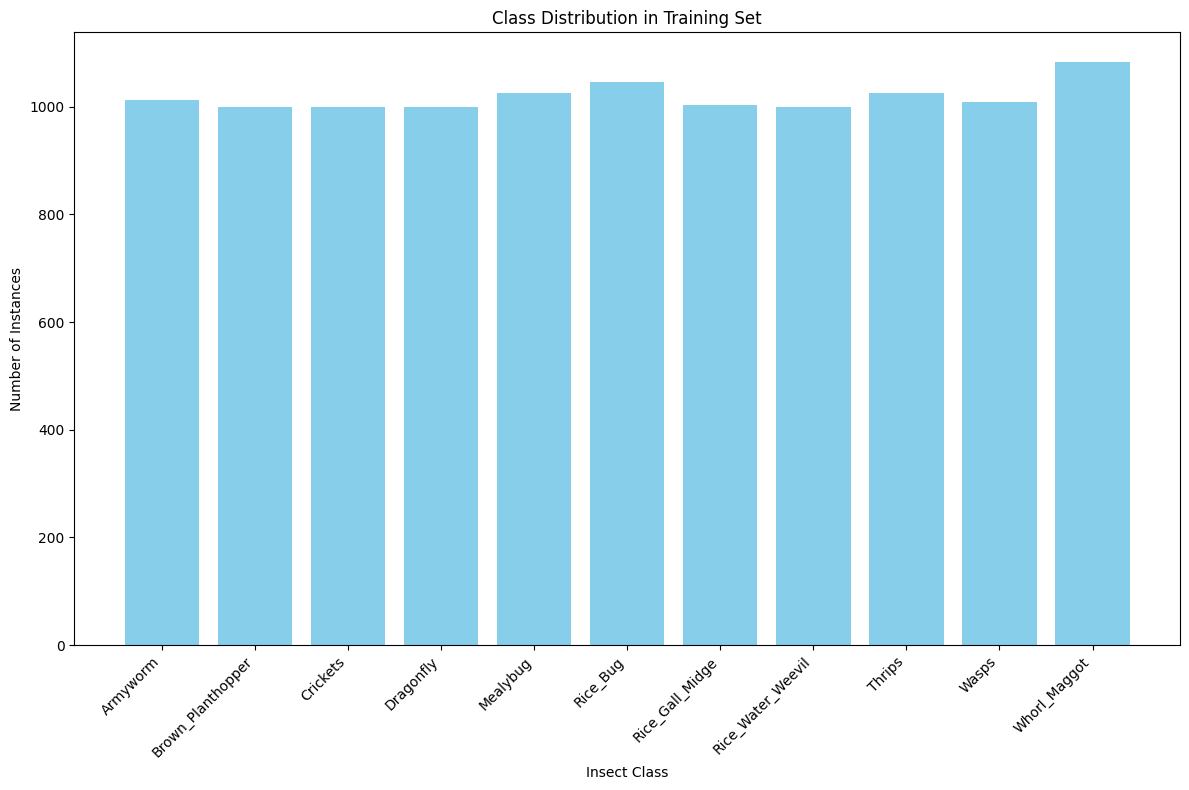

In [10]:
# --- 1. CONFIGURATION ---

yaml_file_path = '/content/Paddy_Insects_Class_Balanced/data.yaml'

# --- 2. LOAD DATA FROM YAML ---
try:
    with open(yaml_file_path, 'r') as file:
        data = yaml.safe_load(file)
        class_names = data['names']
        train_labels_path = os.path.join(os.path.dirname(yaml_file_path), data['train'].replace('../', '')) + '/../labels'

        print(f"Successfully loaded {len(class_names)} classes from {yaml_file_path}")
        print(f"Searching for labels in: {train_labels_path}")

except Exception as e:
    print(f"Error loading or parsing YAML file: {e}")
    # You can stop the script here if the YAML file is not found
    class_names = []
    train_labels_path = ''

# --- 3. COUNT CLASS INSTANCES ---
if class_names and os.path.exists(train_labels_path):
    class_counts = Counter()

    # Loop through all the .txt files in the training labels directory
    for filename in os.listdir(train_labels_path):
        if filename.endswith('.txt'):
            with open(os.path.join(train_labels_path, filename), 'r') as f:
                for line in f:
                    # The class_id is the first number on each line
                    class_id = int(line.split()[0])
                    class_counts[class_id] += 1

    # --- 4. DISPLAY THE RESULTS ---
    print("\n--- Instance Counts per Class ---")

    # Sort the counts by class ID for consistent ordering
    sorted_counts = sorted(class_counts.items())

    for class_id, count in sorted_counts:
        class_name = class_names[class_id]
        print(f"{class_name} (ID: {class_id}): {count} instances")

    # --- 5. VISUALIZE THE RESULTS ---
    class_ids = [item[0] for item in sorted_counts]
    counts = [item[1] for item in sorted_counts]
    names_for_plot = [class_names[id] for id in class_ids]

    plt.figure(figsize=(12, 8))
    plt.bar(names_for_plot, counts, color='skyblue')
    plt.xlabel('Insect Class')
    plt.ylabel('Number of Instances')
    plt.title('Class Distribution in Training Set')
    plt.xticks(rotation=45, ha='right') # Rotate labels to prevent overlap
    plt.tight_layout() # Adjust layout to make room for rotated labels
    plt.show()

else:
    print("\nCould not proceed. Check the path to your data.yaml file or the 'train' directory.")

In [14]:
# Define the path to  balanced dataset's configuration file
data_config_path = '/content/Paddy_Insects_Class_Balanced/data.yaml'

# Load a pre-trained YOLOv8 model. 'yolov8n.pt' is the smallest and fastest.
# 'yolov8s.pt', 'yolov8m.pt' are larger and more accurate but slower.
model = YOLO('yolov8n.pt')

# Train the model on  custom dataset
# The results object will contain information about the training run
results = model.train(
    data='/content/Paddy_Insects_Class_Balanced/data.yaml',
    epochs=75,
    imgsz=640,
    project='/content/drive/MyDrive/Organized_Paddy_Insects_Classification/YOLO_Training_Runs/detect',
    name='yolo_paddy_insect_v1',
    exist_ok=True # Good to add this so you can re-run without errors
)

Ultralytics 8.3.184 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Paddy_Insects_Class_Balanced/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=75, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_paddy_insect_v1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, 

Overriding model.yaml nc=80 with nc=11

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

Model summary: 129 layers, 3,012,993 parameters, 3,012,977 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1396.8±567.5 MB/s, size: 35.2 KB)


train: Scanning /content/Paddy_Insects_Class_Balanced/train/labels... 7517 images, 175 backgrounds, 0 corrupt: 100%|██████████| 7517/7517 [00:02<00:00, 2515.54it/s]


train: New cache created: /content/Paddy_Insects_Class_Balanced/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 203, len(boxes) = 11205. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 752.8±240.2 MB/s, size: 30.6 KB)


val: Scanning /content/Paddy_Insects_Class_Balanced/valid/labels... 1146 images, 40 backgrounds, 0 corrupt: 100%|██████████| 1146/1146 [00:01<00:00, 1079.90it/s]


val: New cache created: /content/Paddy_Insects_Class_Balanced/valid/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 57, len(boxes) = 1821. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
Plotting labels to /content/drive/MyDrive/Organized_Paddy_Insects_Classification/YOLO_Training_Runs/detect/yolo_paddy_insect_v1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Organized_Paddy_Insects_Classification/YOLO_Training_Runs/detect/yolo_paddy_insect_v1
Starting training for 75 epochs...

 

       1/75      2.12G      1.474      3.111      1.736         33        640: 100%|██████████| 470/470 [02:18<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:10<00:00,  3.40it/s]

                   all       1146       1821      0.517      0.436      0.436      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/75      3.08G       1.45      2.308      1.697         38        640: 100%|██████████| 470/470 [02:08<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:08<00:00,  4.13it/s]


                   all       1146       1821      0.641      0.515      0.563      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/75       3.1G       1.44      2.001       1.67         38        640: 100%|██████████| 470/470 [02:07<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.74it/s]


                   all       1146       1821      0.573      0.522      0.537       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/75      3.12G      1.424      1.807      1.652         40        640: 100%|██████████| 470/470 [02:07<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:08<00:00,  4.37it/s]

                   all       1146       1821      0.737      0.596      0.651      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/75      3.13G      1.391      1.665      1.625         47        640: 100%|██████████| 470/470 [02:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.82it/s]


                   all       1146       1821      0.697      0.604      0.653      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/75      3.15G      1.352      1.564      1.593         50        640: 100%|██████████| 470/470 [02:07<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.92it/s]

                   all       1146       1821      0.746      0.703      0.721      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/75      3.17G      1.319       1.44      1.565         38        640: 100%|██████████| 470/470 [02:07<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:08<00:00,  4.34it/s]


                   all       1146       1821      0.762      0.697      0.737      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/75      3.19G      1.302      1.421      1.553         24        640: 100%|██████████| 470/470 [02:06<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.79it/s]


                   all       1146       1821      0.783      0.718      0.737      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/75       3.2G      1.271      1.325      1.534         39        640: 100%|██████████| 470/470 [02:08<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:08<00:00,  4.38it/s]

                   all       1146       1821      0.764      0.724      0.764      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/75      3.22G       1.26      1.283      1.518         40        640: 100%|██████████| 470/470 [02:06<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.83it/s]


                   all       1146       1821      0.796      0.739      0.773      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/75      3.24G      1.232      1.258      1.496         35        640: 100%|██████████| 470/470 [02:08<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.84it/s]

                   all       1146       1821      0.813      0.735      0.776      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/75      3.26G      1.213      1.199      1.482         26        640: 100%|██████████| 470/470 [02:06<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.85it/s]


                   all       1146       1821      0.806      0.743      0.786      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/75      3.27G      1.198      1.186      1.474         32        640: 100%|██████████| 470/470 [02:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:08<00:00,  4.34it/s]

                   all       1146       1821      0.801      0.761      0.789      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/75      3.29G      1.194      1.143      1.465         39        640: 100%|██████████| 470/470 [02:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.92it/s]

                   all       1146       1821      0.826      0.769      0.798      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/75      3.31G       1.17      1.099      1.447         38        640: 100%|██████████| 470/470 [02:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:08<00:00,  4.30it/s]

                   all       1146       1821      0.812      0.761      0.792      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/75      3.32G      1.166      1.105      1.439         54        640: 100%|██████████| 470/470 [02:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:08<00:00,  4.10it/s]


                   all       1146       1821      0.866      0.757      0.803      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/75      3.34G      1.148      1.075       1.43         31        640: 100%|██████████| 470/470 [02:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


                   all       1146       1821      0.775      0.798      0.809      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/75      3.36G      1.135      1.048      1.422         25        640: 100%|██████████| 470/470 [02:06<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:08<00:00,  4.44it/s]

                   all       1146       1821      0.825      0.796      0.823       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/75      3.38G      1.134      1.029      1.411         69        640: 100%|██████████| 470/470 [02:04<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.90it/s]


                   all       1146       1821      0.807      0.808      0.827      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/75      3.39G      1.119      1.013      1.408         21        640: 100%|██████████| 470/470 [02:06<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


                   all       1146       1821      0.847      0.808      0.834      0.544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/75      3.41G      1.107     0.9849      1.401         36        640: 100%|██████████| 470/470 [02:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:07<00:00,  4.57it/s]


                   all       1146       1821      0.823      0.791      0.819      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/75      3.43G      1.093     0.9707      1.396         54        640: 100%|██████████| 470/470 [02:03<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


                   all       1146       1821      0.828      0.783      0.814      0.544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/75      3.44G      1.086     0.9624      1.385         60        640: 100%|██████████| 470/470 [02:05<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:08<00:00,  4.16it/s]

                   all       1146       1821      0.865      0.801      0.831      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/75      3.46G      1.079     0.9387      1.371         34        640: 100%|██████████| 470/470 [02:04<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:10<00:00,  3.56it/s]

                   all       1146       1821      0.852      0.792      0.812       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/75      3.48G      1.066     0.9246      1.373         30        640: 100%|██████████| 470/470 [02:03<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


                   all       1146       1821      0.855      0.807      0.842      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/75      3.49G       1.06     0.9174      1.366         55        640: 100%|██████████| 470/470 [02:07<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


                   all       1146       1821      0.851      0.803      0.839      0.556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/75      3.51G      1.042     0.8888      1.352         36        640: 100%|██████████| 470/470 [02:06<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:07<00:00,  4.56it/s]

                   all       1146       1821      0.858      0.801      0.841      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/75      3.53G      1.048     0.8848      1.356         40        640: 100%|██████████| 470/470 [02:08<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:08<00:00,  4.36it/s]


                   all       1146       1821      0.863      0.805      0.838      0.565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/75      3.54G      1.032     0.8695      1.347         32        640: 100%|██████████| 470/470 [02:06<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.95it/s]

                   all       1146       1821      0.831      0.824      0.831      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/75      3.56G      1.023     0.8618       1.34         25        640: 100%|██████████| 470/470 [02:04<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.89it/s]

                   all       1146       1821      0.848      0.814      0.838       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/75      3.58G      1.035     0.8605      1.344         39        640: 100%|██████████| 470/470 [02:06<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:07<00:00,  4.60it/s]


                   all       1146       1821      0.867      0.822       0.84      0.566

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/75       3.6G      1.019     0.8543      1.337         36        640: 100%|██████████| 470/470 [02:06<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.84it/s]


                   all       1146       1821      0.885      0.815      0.842      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/75      3.61G      1.015     0.8441       1.33         29        640: 100%|██████████| 470/470 [02:08<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.91it/s]


                   all       1146       1821      0.859      0.827      0.851      0.588

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/75      3.63G      1.001     0.8351      1.322         32        640: 100%|██████████| 470/470 [02:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:10<00:00,  3.39it/s]


                   all       1146       1821      0.883      0.822      0.853      0.589

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/75      3.65G     0.9902     0.8102      1.313         33        640: 100%|██████████| 470/470 [02:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:07<00:00,  4.62it/s]


                   all       1146       1821      0.889      0.821      0.851      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/75      3.67G     0.9964     0.8133      1.317         35        640: 100%|██████████| 470/470 [02:07<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.82it/s]


                   all       1146       1821      0.869      0.819      0.843      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/75      3.68G     0.9962      0.807      1.313         30        640: 100%|██████████| 470/470 [02:07<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


                   all       1146       1821      0.889      0.831      0.857      0.591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/75       3.7G     0.9823     0.7848      1.307         63        640: 100%|██████████| 470/470 [02:07<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.95it/s]

                   all       1146       1821      0.882      0.825      0.856      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/75      3.72G     0.9788       0.79      1.307         38        640: 100%|██████████| 470/470 [02:06<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:07<00:00,  4.60it/s]


                   all       1146       1821      0.891      0.825      0.857      0.595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/75      3.73G     0.9741      0.777      1.299         44        640: 100%|██████████| 470/470 [02:08<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:08<00:00,  4.17it/s]


                   all       1146       1821      0.885      0.833      0.856      0.596

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/75      3.75G     0.9635       0.76      1.292         51        640: 100%|██████████| 470/470 [02:08<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


                   all       1146       1821      0.881      0.827      0.856      0.602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/75      3.77G     0.9548     0.7574      1.286         39        640: 100%|██████████| 470/470 [02:08<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.89it/s]


                   all       1146       1821       0.89      0.831      0.858      0.601

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/75      3.79G     0.9603     0.7511       1.29         53        640: 100%|██████████| 470/470 [02:06<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:08<00:00,  4.14it/s]

                   all       1146       1821      0.872      0.838      0.856      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/75       3.8G     0.9501     0.7369      1.276         39        640: 100%|██████████| 470/470 [02:08<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:07<00:00,  4.54it/s]


                   all       1146       1821       0.88      0.844      0.864      0.596

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/75      3.82G     0.9465     0.7509       1.28         42        640: 100%|██████████| 470/470 [02:08<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:08<00:00,  4.14it/s]


                   all       1146       1821       0.87      0.853      0.864      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/75      3.84G     0.9316      0.732      1.268         44        640: 100%|██████████| 470/470 [02:06<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.91it/s]


                   all       1146       1821      0.872      0.847       0.86      0.602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/75      3.85G     0.9303     0.7182      1.267         46        640: 100%|██████████| 470/470 [02:04<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:08<00:00,  4.18it/s]

                   all       1146       1821      0.877      0.839      0.861      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/75      3.87G     0.9315     0.7227      1.273         30        640: 100%|██████████| 470/470 [02:06<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:08<00:00,  4.08it/s]


                   all       1146       1821      0.879       0.83      0.854      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/75      3.89G     0.9214     0.7231      1.263         40        640: 100%|██████████| 470/470 [02:09<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


                   all       1146       1821      0.888      0.829       0.86      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/75       3.9G     0.9193       0.72      1.265         50        640: 100%|██████████| 470/470 [02:07<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.81it/s]


                   all       1146       1821      0.881      0.847      0.867      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/75      3.92G     0.9115     0.6953      1.256         32        640: 100%|██████████| 470/470 [02:07<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.87it/s]


                   all       1146       1821      0.909      0.831      0.868      0.612

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/75      3.94G     0.8854     0.6778      1.244         31        640: 100%|██████████| 470/470 [02:08<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:08<00:00,  4.00it/s]

                   all       1146       1821      0.902      0.821      0.861      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/75      3.96G     0.9001      0.683       1.25         45        640: 100%|██████████| 470/470 [02:08<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:08<00:00,  4.12it/s]

                   all       1146       1821      0.897      0.833      0.873      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/75      3.97G     0.8856     0.6756      1.238         33        640: 100%|██████████| 470/470 [02:09<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:07<00:00,  4.65it/s]


                   all       1146       1821      0.899      0.839      0.869      0.619

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/75      3.99G     0.8894     0.6791       1.24         33        640: 100%|██████████| 470/470 [02:08<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


                   all       1146       1821      0.882      0.851      0.866      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/75      4.01G     0.8817     0.6716      1.236         26        640: 100%|██████████| 470/470 [02:13<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:08<00:00,  4.43it/s]


                   all       1146       1821      0.894      0.841      0.871      0.625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/75      4.02G     0.8802     0.6623      1.239         27        640: 100%|██████████| 470/470 [02:10<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.92it/s]

                   all       1146       1821       0.88      0.866      0.876      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/75      4.04G     0.8718     0.6592      1.235         38        640: 100%|██████████| 470/470 [02:09<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:10<00:00,  3.37it/s]


                   all       1146       1821      0.885      0.858      0.874       0.62

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/75      4.06G     0.8613     0.6453      1.221         33        640: 100%|██████████| 470/470 [02:10<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.86it/s]


                   all       1146       1821      0.884      0.855      0.875      0.627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/75      4.07G     0.8711     0.6484      1.226         41        640: 100%|██████████| 470/470 [02:13<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:08<00:00,  4.11it/s]


                   all       1146       1821      0.895      0.849      0.873      0.625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/75      4.09G     0.8683     0.6548      1.225         44        640: 100%|██████████| 470/470 [02:13<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:08<00:00,  4.48it/s]


                   all       1146       1821      0.887      0.843      0.873      0.626

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/75      4.11G      0.861     0.6425      1.221         40        640: 100%|██████████| 470/470 [02:11<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:08<00:00,  4.47it/s]


                   all       1146       1821      0.897      0.858      0.878      0.629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/75      4.13G     0.8493     0.6322      1.213         39        640: 100%|██████████| 470/470 [02:11<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:08<00:00,  4.36it/s]


                   all       1146       1821      0.903       0.86      0.878      0.626

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/75      4.14G     0.8416     0.6188      1.211         31        640: 100%|██████████| 470/470 [02:12<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:08<00:00,  4.35it/s]


                   all       1146       1821      0.902      0.855      0.879      0.628

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/75      4.16G     0.8486     0.6298      1.213         35        640: 100%|██████████| 470/470 [02:12<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:08<00:00,  4.19it/s]

                   all       1146       1821      0.895      0.859      0.881      0.633


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/75      4.18G     0.8073      0.494      1.228         14        640: 100%|██████████| 470/470 [02:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:08<00:00,  4.13it/s]


                   all       1146       1821      0.909      0.849      0.877      0.632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/75       4.2G     0.7875     0.4682      1.217         14        640: 100%|██████████| 470/470 [02:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.84it/s]


                   all       1146       1821      0.897      0.863      0.878      0.627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/75      4.21G     0.7771     0.4591      1.203         21        640: 100%|██████████| 470/470 [02:06<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:08<00:00,  4.38it/s]

                   all       1146       1821      0.903      0.858      0.878      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/75      4.23G     0.7757     0.4572      1.204         18        640: 100%|██████████| 470/470 [02:03<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.84it/s]


                   all       1146       1821      0.904       0.85      0.877      0.632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/75      4.25G     0.7592     0.4483      1.191         20        640: 100%|██████████| 470/470 [02:04<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:08<00:00,  4.09it/s]

                   all       1146       1821        0.9      0.855      0.878      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/75      4.26G     0.7562     0.4435      1.192         32        640: 100%|██████████| 470/470 [02:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:08<00:00,  4.15it/s]


                   all       1146       1821      0.903      0.855       0.88      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/75      4.28G     0.7534     0.4471       1.19         14        640: 100%|██████████| 470/470 [02:02<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:08<00:00,  4.21it/s]

                   all       1146       1821      0.904      0.855       0.88      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/75       4.3G     0.7364     0.4326       1.18         16        640: 100%|██████████| 470/470 [02:03<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


                   all       1146       1821      0.905      0.853      0.878      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/75      4.31G     0.7448     0.4348      1.183         42        640: 100%|██████████| 470/470 [02:04<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:08<00:00,  4.46it/s]


                   all       1146       1821      0.903      0.857      0.877      0.632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/75      4.33G     0.7362     0.4292      1.175         17        640: 100%|██████████| 470/470 [02:04<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.88it/s]


                   all       1146       1821      0.901      0.856      0.877      0.631

75 epochs completed in 2.847 hours.
Optimizer stripped from /content/drive/MyDrive/Organized_Paddy_Insects_Classification/YOLO_Training_Runs/detect/yolo_paddy_insect_v1/weights/last.pt, 6.3MB
Optimizer stripped from /content/drive/MyDrive/Organized_Paddy_Insects_Classification/YOLO_Training_Runs/detect/yolo_paddy_insect_v1/weights/best.pt, 6.3MB

Validating /content/drive/MyDrive/Organized_Paddy_Insects_Classification/YOLO_Training_Runs/detect/yolo_paddy_insect_v1/weights/best.pt...
Ultralytics 8.3.184 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,793 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:11<00:00,  3.14it/s]


                   all       1146       1821      0.904      0.855       0.88      0.634
              Armyworm         71        198      0.821      0.787      0.831      0.421
     Brown_Planthopper         30        136       0.82       0.37      0.463      0.225
              Crickets        125        125      0.996          1      0.995      0.785
             Dragonfly         26         26      0.944      0.962      0.973      0.741
              Mealybug        150        199      0.957      0.779      0.853      0.632
              Rice_Bug         17         18      0.772      0.833      0.782      0.454
       Rice_Gall_Midge        114        136      0.948      0.939       0.97      0.787
     Rice_Water_Weevil        167        200       0.94          1      0.991      0.923
                Thrips        176        233      0.891       0.97      0.932      0.694
                 Wasps        169        396      0.949      0.904      0.971      0.572
          Whorl_Maggo